In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('../data/processed/trials.csv')
data.drop(columns='nct_id', inplace=True)

C:\Users\olive\AppData\Local\Temp\ipykernel_10600\2384231012.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/processed/trials.csv')


In [4]:
print("missing values for categorical columns:")
data[[col for col in data.columns if data[col].dtype == np.object_]].isna().mean().sort_values(ascending=False)

missing values for categorical columns:


is_ppsd                    0.999982
is_unapproved_device       0.993142
biospec_retention          0.962940
phase                      0.579570
is_fda_regulated_device    0.529242
is_fda_regulated_drug      0.529219
maximum_age_unit           0.464688
primary_purpose            0.225750
has_us_facility            0.073943
minimum_age_unit           0.065464
model                      0.030299
agency_class               0.000000
dtype: float64

In [5]:
print("missing values for numerical columns:")
data[[col for col in data.columns if data[col].dtype in [np.float64, np.int64]]].isna().mean().sort_values(ascending=False)

missing values for numerical columns:


number_of_groups                           0.863114
maximum_age_num                            0.464688
number_of_secondary_outcomes_to_measure    0.278330
number_of_arms                             0.266084
minimum_age_num                            0.065464
num_countries                              0.062624
number_of_primary_outcomes_to_measure      0.036963
number_of_facilities                       0.000000
dtype: float64

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)

from sklearn.model_selection import cross_validate, train_test_split

In [7]:
num_groups = data['number_of_groups']
num_groups_mode = num_groups[num_groups.notna()].mode()[0]
num_groups.fillna(num_groups_mode)
data['number_of_groups'] = num_groups.fillna(num_groups_mode)

In [8]:
data.drop(columns=[ 'is_ppsd',], inplace=True)

In [9]:
X = data.drop(columns='terminated')
y = data['terminated']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=915, test_size=0.25, stratify=y)

In [10]:
data['number_of_secondary_outcomes_to_measure'].describe()

count    244444.000000
mean          5.166672
std           6.971905
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         324.000000
Name: number_of_secondary_outcomes_to_measure, dtype: float64

In [27]:
categorical_features = [col for col in data.columns if data[col].dtype == np.object_] 
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

heavy_tailed_features = [
    'number_of_facilities', 'num_countries',
    'number_of_secondary_outcomes_to_measure',
    'number_of_groups'
    ]
heavy_tailed_tranformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median', add_indicator=True)),
    ('log1p', FunctionTransformer(func=np.log1p)),
    ('scale', StandardScaler()),
]
)

numerical_features = [col for col in data.columns if (data[col].dtype in [np.int64, np.float64]) and (col not in heavy_tailed_features)]
numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median', add_indicator=True)),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transf', categorical_transformer, categorical_features),
        ('heavy_tailed_transf', heavy_tailed_tranformer, heavy_tailed_features),
        ('num_transf', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('log_reg', LogisticRegression())
    ]

)

In [12]:
result = cross_validate(pipeline, X_train, y_train, cv=5, scoring='average_precision')
cv_ap = result['test_score'].mean()
print("cv ap = ", result['test_score'].mean())

cv ap =  0.20147099266497426


In [13]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
proba = pipeline.predict_proba(X_test)[:, 1]

PR curve (AP = 0.211153, CV AP= 0.201471 prevalence = 0.095678)


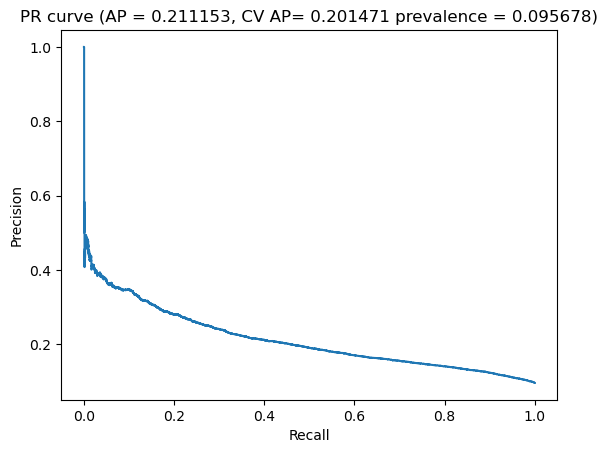

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)


print(f"PR curve (AP = {ap:.6f}, CV AP= {cv_ap:.6f} prevalence = {y_test.mean():.6f})")
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR curve (AP = {ap:.6f}, CV AP= {cv_ap:.6f} prevalence = {y_test.mean():.6f})")
plt.show()

In [15]:
pipeline.score(X_test, y_test)

0.9043457723193198

In [16]:
print("Positive rate in test:", y_test.mean())
print("Predicted positive rate:", y_pred.mean())

Positive rate in test: 0.0956778460085026
Predicted positive rate: 4.723665564478035e-05


In [17]:
proba = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC (Average Precision):", average_precision_score(y_test, proba))
print(confusion_matrix(y_test, (proba >= 0.5)))
print(classification_report(y_test, (proba >= 0.5), digits=3))

ROC-AUC: 0.7070722656058728
PR-AUC (Average Precision): 0.21115300336329781
[[76577     1]
 [ 8099     3]]
              precision    recall  f1-score   support

       False      0.904     1.000     0.950     76578
        True      0.750     0.000     0.001      8102

    accuracy                          0.904     84680
   macro avg      0.827     0.500     0.475     84680
weighted avg      0.890     0.904     0.859     84680



## SVM

In [18]:
from sklearn.svm import SVC, LinearSVC

In [19]:
svc_pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('svc', LinearSVC())
    ]
)

In [20]:
# svc_result = cross_validate(svc_pipeline, X_train, y_train, cv=5, scoring='average_precision')
# svc_cv_ap = svc_result['test_score'].mean()
# svc_cv_ap

In [21]:
# svc_pipeline.fit(X_train, y_train)
# y_pred = svc_pipeline.predict(X_test)
# proba = svc_pipeline.predict_proba(X_test)[:, 1]

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier

In [28]:
models = {
    'logreg':LogisticRegression(),
    'logreg_bal':LogisticRegression(class_weight='balanced'),
    'lin_svc':LinearSVC(),
    'lin_svc_bal':LinearSVC(class_weight='balanced'),
    'hgb':HistGradientBoostingClassifier(random_state=1107)
}

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', clf)
    ])
    scores = cross_validate(
        pipe, X_train, y_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1107),
        scoring={'ap':'average_precision', 'roc':'roc_auc'},
        n_jobs=-1
    )
    print(
        name, '|',
        'AP:', f"{scores['test_ap'].mean():.6f}",
        'ROC:', f"{scores['test_roc'].mean():.6f}"
    )

logreg | AP: 0.201735 ROC: 0.704311
logreg_bal | AP: 0.199434 ROC: 0.704493
lin_svc | AP: 0.202212 ROC: 0.702737
lin_svc_bal | AP: 0.198637 ROC: 0.704428
hgb | AP: 0.225027 ROC: 0.729616


In [31]:
def pm(x, y):
    return x + y, x - y

In [32]:
pm(3, 2)

(5, 1)